# 1 Introduction

This notebook was created for the purpose:

* Creating an LSTM model
* Creating a SARIMAX/ARIMA model (done)
* Creating an FB Prophet model
* Bagging the three models into the final predictor

## 1.1 Google Colab Mount

First I have to mount my Google Drive so that I can load the CSV file for the dataset.

In [1]:
from google.colab import drive
drive.mount('/content/Gdrive')
% cd '/content/Gdrive/My Drive/Colab Notebooks/Traffic_Forecasting'
! ls

Drive already mounted at /content/Gdrive; to attempt to forcibly remount, call drive.mount("/content/Gdrive", force_remount=True).
/content/Gdrive/My Drive/Colab Notebooks/Traffic_Forecasting
 aigrabsea_June3.ipynb		      Encoded_data.pkl
 auto_encoder_06062019.h5	      encoder_06062019.h5
 auto_encoder_Updated_06142019.h5     Forecast_LSTM-June142019.h5
 auto_encoder_Updated.h5	      geo_mean_dict.pickle
 auto_encoder_Updated-June142019.h5   heatmap
 auto_encoder_weights_06062019.h5     heatmap-animation-WK2.gif
'Copy of requirements.txt'	      lat_lookup.pickle
 data_encoded.pickle		      line.gif
'Dataset-Explore(output-off).ipynb'   long_lookup.pickle
 data_w_features.pickle		      requirements.txt
 decoder_06062019.h5		     'Traffic Management'
 EDA-Notes.ipynb		      traffic-management.zip


## 1.2 Dependecies Load

Below are the known dependencies I will be using for the notebook. One particular dependency that has to be modified when working with Google Colab is scipy. The scipy version on the default Colab session is version 1.3. This version is having issues on the statsmodel so we have to manually downgrade the version. This is done in this section because this would require a restart of the runtime for the lower version to be loaded.

In [2]:
!pip install scipy==1.2

In [0]:
# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation,PillowWriter
import seaborn as sns
import numpy as np
import pickle
import math
import time
from fbprophet import Prophet
from math import log10
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm_notebook

from IPython.display import HTML, Image

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,10
rcParams['figure.dpi'] = 75
rcParams['agg.path.chunksize'] = 10000
rcParams['animation.html'] = 'html5'
plt.rcParams['axes.facecolor'] = 'white'

pd.set_option('display.max_row', 1000)
pd.set_option('display.max_column', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x) # Just to make some floats easier to look at. Will not change dtype.

## 1.3 Dataset Load

Using Pandas `read_csv` I can load up the dataset.

> **NOTE**: If this is going to be tested, I suggest that the holdout data be loaded in this portion as well and concatenated to the training dataset so that the preprocessing can be applied on one go. This should help avoid potential issues when preprocessing them separately and concatenating after.

In [4]:
data = pd.read_csv('./Traffic Management/training.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4206321 entries, 0 to 4206320
Data columns (total 4 columns):
geohash6     object
day          int64
timestamp    object
demand       float64
dtypes: float64(1), int64(1), object(2)
memory usage: 128.4+ MB


## 1.4 Miscellaneous Functions

In [0]:
# Misc Functions
# Basic RMS function.

def RMS(pred_val, true_val):
    return math.sqrt(((true_val-pred_val)**2).mean())

def sklearn_RMS(pred_val, true_val):
    from sklearn.metrics import mean_squared_error
    return (mean_squared_error(true_val, pred_val))**0.5

# 2 Dataset Features

In [6]:
data.head()

,geohash6,day,timestamp,demand
0,qp03wc,18,20:0,0.020072
1,qp03pn,10,14:30,0.024721
2,qp09sw,9,6:15,0.102821
3,qp0991,32,5:0,0.088755
4,qp090q,15,4:0,0.074468


## 2.1 Adding Features

### Temporal

**get_time** - Splits the `timestamp` to the `hour` and `minute` values. `timestamp`will be dropped and the `minute` and `hour` values will be added to the dataframe.

**data_add_year** - Adds an arbitrary year column. In this case I chose to use `2019`. This is an arbitrary value, we should be able to change this if we have the actual year but for the purposes of getting a valid `datetime` index I am adding `2019`. This would simply add a column to the dataframe with the selected year value.

**add_mnth** - Another arbitrary value selection. Created for the purposes of  having a `datetime` index later on. The months chosen are *March* and *April*.  This should be able to handle data until `May`.<br>
> **NOTE**:If new data would be added to the dataframe the `day` should be continued from day 61. For example, if the model would be later asked to predict D+10, then that would be day 71. Otherwise the data would be resolved to Day 10 which would lead to duplicate demand which could potentially break the model.

**add_mnth_day** - Adding day of the month value to the dataframe.  This is hardcoded and will not be able to handle continuity on February where the days are 28 or 29. This assumes that all months are alternating 30 and 31 days.

**check_day** - Adding the day of the week based on the day value. Do note that this is not an accurate representative of the acutal day of the week, 1 should not be assumed to mean Monday, 2 is not assumed Tuesday.

**add_stamp** - Adds a pandas DateTimeIndex values to the list to correspond to the date and time of the data.

### Spatial

**lat_long_lookup** - Looksup the latitude and longitude of the data point given the geohash value. Note that `lat_lookup` and `long_lookup` were created based on Python Geohash module, `decode_exactly` function. Since the challenge rule states that the holdoff data would be within the same set as the test data I decided to create a lookup table for faster retrieval of latitude and longitude values.

**geohash_encode_lookup** - Adds a unique integer geohash identifier for every geohash6 value available on the data. Uses `LabelEncoder` from sklearn.

In [0]:
def get_time(data):
    hour = []
    minute = []
    for item in data['timestamp']:
        hour.append(item.rsplit(sep=':')[0])
        minute.append(item.rsplit(sep=':')[1])
    data['hour'] = hour
    data['minute'] = minute
    data.hour = pd.to_numeric(data.hour, errors = 'coerce').astype(np.int16)
    data.minute = pd.to_numeric(data.minute, errors = 'coerce').astype(np.int16)
#     data = data.drop('timestamp', axis = 1)
    return data

def data_add_year(data):
    data['year'] = 2019 # Arbitrary year
    return data

def add_mnth(data):
    '''
    Adding arbitrary date, just to make it easier for datetime conversion and arrange the data
    '''
    month=[]
    for item in data['day']:
        if item <= 31:
            month.append(3) # March 2019
        elif item >31 & item <=61:
            month.append(4) # April 2019
        else:
            month.append(5) # May 2019 (Arbitrary). This would fail the `days` value gets past the days for May 2019.
    data['month'] = month
    return data

def add_mnth_day(data):
    mnth_day = []
    for item in data['day']:
        if item > 61:
            day = item%61
        else:
            day=item
        mnth_day.append((day)%31)
    data['mnth_day'] = mnth_day
    data.loc[data['mnth_day']==0, 'mnth_day']=31 # Fixing days that will be 0 instead of 31
    return data

def check_day(data):
    '''
    Checking the day of the week based on the value of day_index
    Do note that this is also arbitrary since I do not know when exactly the timeframe started.
    Adding this since there must be some factor of the time of date and I would like for my regressor to figure it out if possible.
    '''
    lookup = {1:1,2:2,3:3,4:4,5:5,6:6,0:7}
    dow = []
    for item in data['day']:
        dow.append(lookup.get(item%7))
    data['dow'] = dow
    return data

def add_stamp(data):
    data['date'] = pd.to_datetime({'day':data.mnth_day,
                               'month':data.month,
                               'year':data.year,
                               'hour':data.hour,
                               'minute':data.minute                              
                              })
    data['date']=pd.to_datetime(data.date,format='%Y-%m-%d-%H:%M')
    return data

def lat_long_lookup(data):
    '''
    Decoding the latitude and longitude the individual Geohash codes.
    Via Lookup table
    '''
    lat_lookup = pickle.load(open('lat_lookup.pickle','rb'))
    long_lookup = pickle.load(open('long_lookup.pickle','rb'))
    lat = []
    long = []
    for item in data['geohash6']:
        lat.append(lat_lookup.get(item))
        long.append(long_lookup.get(item))
    data['lat_lookup'] = lat
    data['long_lookup'] = long
    return data

def geohash_encode_lookup(data):
    from sklearn.preprocessing import LabelEncoder
    geo_encoder = LabelEncoder()
    
    data['geo_encoded']=geo_encoder.fit_transform(data['geohash6'])
    return data


## 2.2 Preprocessing pipeline

The `data_process` function below acts as the processing pipeline for the dataframe. We can choose to add or remove preprocessing steps by commenting out or appending the included preprocessing functions.<br><br>
> **Note**: It is assumed that the dataframe up until the final date point prior to the prediction has been included in the `data`. This helps ensure that there would be minimal bugs in the preprocessing. I believe this would be safer than adding features to the original data and the holdoff data separately and concatenating them afterwards.

In [0]:
def data_process(data):
    data = get_time(data)
    data = data_add_year(data)
    data = add_mnth(data)
    data = add_mnth_day(data)
    data = check_day(data)
    data = add_stamp(data)
    data = lat_long_lookup(data)
    data = geohash_encode_lookup(data)
    data.sort_values(by=['date'], inplace=True)
    data.reset_index(inplace=True)
    data.drop('index',inplace=True, axis=1)
    return data

### 2.2.1 Applying Features

Running the code below would add all the feature columns to the dataset `data`. On the entire *Demand dataset* given during the challenge it takes about 25 seconds to complete.

In [9]:
%%time
data = data_process(data)

CPU times: user 26.4 s, sys: 2.41 s, total: 28.8 s
Wall time: 28.8 s


In [10]:
data.tail()

,geohash6,day,timestamp,demand,hour,minute,year,month,mnth_day,dow,date,lat_lookup,long_lookup,geo_encoded
4206316,qp09sw,61,23:45,0.035813,23,45,2019,4,30,5,2019-04-30 23:45:00,-5.325623,90.906372,1056
4206317,qp03zh,61,23:45,0.010722,23,45,2019,4,30,5,2019-04-30 23:45:00,-5.292664,90.664673,311
4206318,qp09dm,61,23:45,0.015853,23,45,2019,4,30,5,2019-04-30 23:45:00,-5.331116,90.807495,804
4206319,qp09u2,61,23:45,0.023380,23,45,2019,4,30,5,2019-04-30 23:45:00,-5.314636,90.895386,1089
4206320,qp03wz,61,23:45,0.159342,23,45,2019,4,30,5,2019-04-30 23:45:00,-5.320129,90.653687,232


# 3-4 EDA

The EDA Portion of the notes are in the EDA-Notes.ipynb notebook.

# 5 Prediction Model Approach

Now that I have completed the analysis of data I can now move on with the creation of the model which is the second part of the challenge. I have no prior experience to time-series analysis, especially forecasting so its quite new to me. I have been reading up some guidelines on how to approach these types of challenge and knowing what is available our there versus knowing what I know(or don't know) I decided on the following guidelines. Since I have no prior experience, I intend to use the simplest model I can with the highest accuracy I can get. To reduce the complexity of the models, I decided to frame the problem as univariate time series with multi-step forecasting. [Machine Learning Mastery](https://machinelearningmastery.com/start-here/#deep_learning_time_series) was quite helpful in creating the frame work of the approach to the problem.
    
General Flow:

* **
**Encode Data** - The original data needs to be transformed from individual entries of geohashes to a single value for it to fit the univariate framework.<br>
**Forecast** - Once the data has been encoded I will train different univariate time-series models to compare results.<br>
**Decode Data** - As a requirement for evaluation, the forecasts have to be converted back to their original geohash6 bins so that an RMSE can be retrieved. For this I will need a decoder module.
* **


Specific Flow:

* Pivot Table
* Get Mask
* Encode Table
* Model Forecast
* Decode Table
* Mask * Decoded
* Get RMS of True and Mask * Decoded

### Model Scoring

Now that we have a working model that can go forward in time, we can now start scoring the model based on the metrics that will be used in the challenge evaluation. From the challenge web page, the model is supposed to be evaluted on RMS per 15-minute bucket per geohash6 location. This means that I will have to revert my encoded forecasts. For the following steps we are going to get the score for the decoded model, the score for the encoded model and the score for the last 5 predictions of the model.

* **Decoded Model Score** - Represents how well the model scored in terms of the per geohash6 per 15-minute bucket for all the predictions prior to the last 5 items.
* **Encoded Model Score** - Represents how well the encoded predictions from the model were compared to the acutal encoded model value.
* **Final 5 Score** - The score for the last 5 forecast of the model. This is the score for the final 5 forecast items when decoded. This is, as I understand, similar to how the model will be scored in the evaluation. This is also not similar to the Decoded Model score since this uses all the forecasted values (5 items) compared to the Decoded Model score which is updated only on the first forecast item.

In [0]:
def get_score(forecast_frame,current,walk_point):
    decoded_SARIMA = decoder_2.predict(forecast_frame)# note:  using decoder 2
    actual_SARIMA = upsample[-current:(-current+walk_point)] # - current : -current + f_steps
    mask_SARIMA = mask_[-current:(-current+walk_point)] # - current : -current + f_steps
    masked_SARIMA = pd.DataFrame(decoded_SARIMA*mask_SARIMA,columns=upsample.columns)
    model_score = RMS(masked_SARIMA.values,actual_SARIMA.values)
    print('Full Decoded Model Score: ',model_score)
    return model_score


In [0]:
def final_five_score(dataset,y_hat_last,current,walk_point,f_steps):
    final_five = pd.DataFrame(columns = ['preds','true'])
    final_five['preds'] = y_hat_last
    final_five['true'] = dataset.values[(-current+walk_point):(-current+walk_point+f_steps)]
    score=RMS(final_five['preds'],final_five['true'])
    print('Encoded Preds Score:',score)
    decoded_SARIMA = decoder_2.predict(final_five['preds'])# note:  using decoder 2
    actual_SARIMA = upsample[(-current+walk_point):(-current+walk_point+f_steps)] # - current : -current + f_steps
    mask_SARIMA = mask_[(-current+walk_point):(-current+walk_point+f_steps)] # - current : -current + f_steps
    masked_SARIMA = pd.DataFrame(decoded_SARIMA*mask_SARIMA,columns=upsample.columns)
    decoded_model_score = RMS(masked_SARIMA.values,actual_SARIMA.values)
    print('Final Five Model Score: ',decoded_model_score)
    return score,decoded_model_score

## Pivot Data

My idea is that I need the data to be arranged by date and their respective geo_encoded identifier. Luckily, Pandas can take care of it for me via `pivot_table`.  Since I am not sure how to fill in missing values of demand I am currently setting the fill value to 0. It could make sense for areas that have missing values to use the average for that demand although I think that would not be representative of the actual demand for that location.

**NOTE to self** - It could be possible to create an array representation of the data per Date based on lat and long.<br>
```
date_data_array = []
for date in data['date']:
    holder = data.loc[date['date']==date]
    long_lat = holder.pivot_table(index = 'longitude', columns='latitude', values='demand', fill_value = 0)
    date_data_array.append(long_lat.values)
```

The idea would be to create a representation of the data in 2D. With this I can make use of a CNN to get features that would take into considertion the effects of surrounding geohashes to a certain geohash demand. This would be useful because spatial information, like an image, is in 2D. So far, I have not yet implemented this.
    


In [11]:
%%time
pivot = data.pivot_table(index= 'date', columns='geo_encoded', values='demand', fill_value=0)
pivot.sort_values(by=['date'], inplace=True)

CPU times: user 4.02 s, sys: 51.9 ms, total: 4.07 s
Wall time: 4.07 s


### Case of Missing Dates

In [12]:
%%time
full_date = pd.date_range(start=data['date'].min(), end= data['date'].max(), freq='15T')
dates_list = list(set(data['date']))
missing = []
for item in full_date:
    if item not in dates_list:
        missing.append(item)
print('Missing entries:',len(missing))
print(missing)

Missing entries: 9
[Timestamp('2019-03-18 09:45:00', freq='15T'), Timestamp('2019-03-18 10:00:00', freq='15T'), Timestamp('2019-03-18 10:15:00', freq='15T'), Timestamp('2019-03-18 11:30:00', freq='15T'), Timestamp('2019-03-18 11:45:00', freq='15T'), Timestamp('2019-03-18 12:00:00', freq='15T'), Timestamp('2019-03-18 12:15:00', freq='15T'), Timestamp('2019-03-18 12:30:00', freq='15T'), Timestamp('2019-03-18 12:45:00', freq='15T')]
CPU times: user 11.2 s, sys: 6.4 ms, total: 11.2 s
Wall time: 11.2 s


In [13]:
print('Pivot Table Entries: {}\nExpected Date Entries: {}\nMissing Date count: {}'.format(len(pivot),len(full_date),(len(full_date)-len(pivot))))

Pivot Table Entries: 5847
Expected Date Entries: 5856
Missing Date count: 9


### Filling missing values

A check on the full date showed that there were 9 missing data points for the dataset. I am not sure how it should be properly filled so I made a call to use nearest as the fill method.

In [0]:
# upsample = pivot.resample('15T').asfreq(fill_value=0).reset_index()
upsample = pivot.resample('15T').interpolate(method='linear').reset_index()
upsample.set_index('date',inplace=True)

In [15]:
RMS(pivot.head(100).values,upsample.head(100).values)

0.0

## Creating Masking Table

In this part I am simply creating a masking table for the dataset. The idea behind it is that I need to make sure that the RMS would be computed only on locations that originally had data in the first place. The autoencoder could come up with values for certain locations even when there was originally no data at that location for a given time so to ensure I at least get a fair RMS I have to mask out those predictions that were not there to begin with.<br><br>
For this portion I am simply checking which elements of the data that was pivoted had values greater than 0. Knowing that all fill values were 0 and the minimum value for the demand was close but not equal to zero, I decided to create a simple mask by comparing the values of each element to zero. All values greater than 0 would be considered valid and therefore would be masked by 1. All the elements that were originally 0 were retained at 0.

In [16]:
%%time
mask_ = pd.DataFrame(np.where((upsample)>0,1,(upsample)))

CPU times: user 562 ms, sys: 15.9 ms, total: 577 ms
Wall time: 581 ms


## Sample Masking

Below, I am checking the results of the masking. If it all went as planned the RMS should be 0 and the table values should be an identity.

In [17]:
%%time
masked = pd.DataFrame(upsample.values*mask_.values,columns=upsample.columns,index = upsample.index)

CPU times: user 26 ms, sys: 698 µs, total: 26.7 ms
Wall time: 28.4 ms


Below is the RMS of the masked data and the pivot table. I can see that the masking table worked as intended. Since masked and pivot are identity then they should have a 0 RMS.

In [18]:
RMS(masked.values,upsample.values)

0.0

# 6 Autoencoder Load

Now that I have a pivoted data arranged per date and by encoded value, I can proceed with the creation of the autoencoder model. Prior to this notebook I have already created an autoencoder trained on getting the upsampled data and reducing it to a single value representation.

```python
# Structure of the Loaded Autoencoder 06062019.h5
import keras
from keras.layers import Dense, Input, Dropout
from keras.models import Model

input_array = Input(shape=(1329,))
encoded = Dense(units = 512, activation='relu')(input_array)
encoded = Dropout(rate=0.5)(encoded)
encoded = Dense(units = 256, activation='relu')(encoded)
encoded = Dropout(rate=0.5)(encoded)
encoded = Dense(units = 128, activation='relu')(encoded)
encoded = Dropout(rate=0.5)(encoded)
encoded = Dense(units = 64, activation='relu')(encoded)
encoded = Dropout(rate=0.5)(encoded)
encoded = Dense(units = 1, activation='linear')(encoded)
decoded = Dense(units = 64, activation='relu')(encoded)
decoded = Dropout(rate=0.5)(decoded)
decoded = Dense(units = 128, activation='relu')(decoded)
decoded = Dropout(rate=0.5)(decoded)
decoded = Dense(units = 256, activation='relu')(decoded)
decoded = Dropout(rate=0.5)(decoded)
decoded = Dense(units = 512, activation='relu')(decoded)
decoded = Dropout(rate=0.5)(decoded)
decoded = Dense(units = 1329, activation='linear')(decoded)
```

I have copied the original code for the loaded model above. For some reason I am not able to reproduce the results I wanted using a better autoencoder model (with kernel initialization and more custom optimizer) so I am sticking to this loaded model for now. Below is the compilation and training of the model with all things including optimizer adam set to the default.

```python
%%time
auto_encoder.compile(optimizer='adam', loss='mse', metrics=['mse'])
history = auto_encoder.fit(demand_array[:4000],demand_array[:4000],
                epochs=50,
                batch_size=256,
                verbose=1,
                validation_data=(demand_array[4000:5000],demand_array[4000:5000])
                )
```

I'll try to circle back here and add the Model Loss graph as well but for reference it has a Validation Loss of ~0.006 and a Training Loss of ~0.002. As we can see there is quite a big gap between the train and val losses which could be addressed by better use of the optimizer and adding some kernel initialization. These steps has been implemented on the next chapter: New Autoencoder Train although I am sticking to this model for the encoding and decoding of the data for my time-series models.

In [19]:
from keras.layers import Dense, Input, Dropout
from keras.models import Model
from keras.models import load_model

# auto_encoder = load_model('auto_encoder_06062019.h5')
auto_encoder = load_model('auto_encoder_Updated-June142019.h5')
auto_encoder.summary()

Using TensorFlow backend.
W0614 19:50:51.662198 140037066422144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0614 19:50:51.681691 140037066422144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0614 19:50:51.734125 140037066422144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0614 19:50:51.740561 140037066422144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_de

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 1329)              0         
_________________________________________________________________
enc_1 (Dense)                (None, 512)               680960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
enc_2 (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
enc_3 (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

### Encoder and Decoder Module

For the **Encoder** the model is from the input until `dense_85` layer where the final encoded value can be retrieved. This layer also serves as the input interface of the decoder module which I am using to convert back to the original geoencoded demands the predicted univariate forecasts.

In [20]:
encoder = Model(auto_encoder.input,auto_encoder.layers[-10].output)
encoder.summary()
decoder_input = Input(shape=(1,))
decoded = auto_encoder.layers[-9](decoder_input)
decoded = auto_encoder.layers[-8](decoded)
decoded = auto_encoder.layers[-7](decoded)
decoded = auto_encoder.layers[-6](decoded)
decoded = auto_encoder.layers[-5](decoded)
decoded = auto_encoder.layers[-4](decoded)
decoded = auto_encoder.layers[-3](decoded)
decoded = auto_encoder.layers[-2](decoded)
decoded = auto_encoder.layers[-1](decoded)

decoder=Model(decoder_input,decoded)
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 1329)              0         
_________________________________________________________________
enc_1 (Dense)                (None, 512)               680960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
enc_2 (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
enc_3 (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

### Encoding

In [25]:
%%time
encoded = encoder.predict(upsample.values)

CPU times: user 971 ms, sys: 81.2 ms, total: 1.05 s
Wall time: 765 ms


In [0]:
upsample['encoded'] = encoded

In [27]:
print(upsample['encoded'].max(),upsample['encoded'].min())

9.296316 -0.27296025


In [28]:
upsample.values.min()

-0.27296024560928345

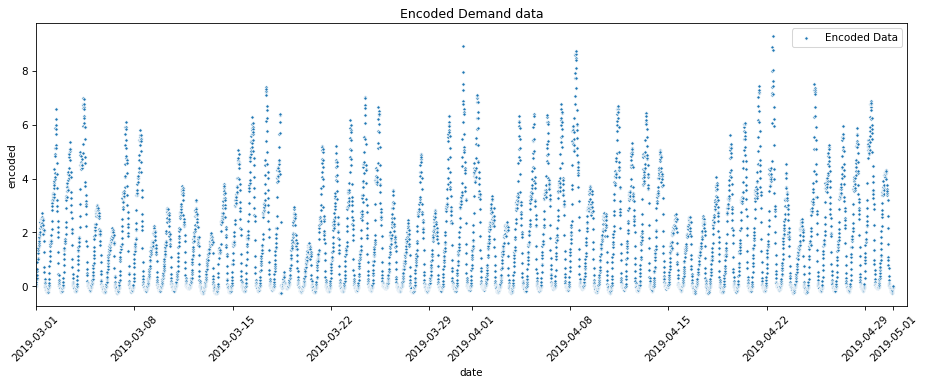

In [30]:
fig, ax = plt.subplots(figsize=(15,5), dpi=75)
# Saving data/notebook size. For better plot, Comment out the line above and uncomment the one below.
# fig, ax = plt.subplots(figsize=(100,10), dpi=100)
# Adding date and demand
ax = sns.scatterplot(x=upsample.index,y=upsample['encoded'],label = 'Encoded Data', s=10)
ax.set_xlim([pd.to_datetime('2019-02-28 23:50:00'), pd.to_datetime('2019-05-02 00:10:00')])
ax.set_title('Encoded Demand data')
# Rotate the dates
for item in ax.get_xticklabels():
    item.set_rotation(45)

In [0]:
upsample.drop('encoded',axis = 1, inplace=True)

In [48]:
upsample.shape

(5856, 1329)

In [34]:
%%time
decoded = decoder.predict(encoded)

CPU times: user 748 ms, sys: 35.1 ms, total: 783 ms
Wall time: 455 ms


In [35]:
decoded.shape

(5856, 1329)

## Creating the Encoded Dataset

Below are my steps on encoding the upsample dataset. What happens is that the 1329 individual geoencoded demands are encoded into a single value. From there I can now use the encoded demands to use models that require univariate inputs. Its important to note that losses in the autoencoder will inevitably propagate back to the actual RMS score for the model. This is the reason why the autoencoder is a bit important. A high loss here, even if our time-series prediction model is so acurate, would still give out a bad result. All the "features" that would be relevant are already captured by the Neural Network layers.

One possible imporvement for the MLP would be to use a CNN autoencoder. The idea would be to first arrange the demand on the long and lat levels. This way when we pass the long and lat arranged data our CNN would be able to figure out the effect of the surrounding areas to the demand as well. 

In [21]:
%%time
encoded = encoder.predict(upsample.values[:])
encoded_data = pd.DataFrame(index = upsample.index, columns=['encoded'])
encoded_data['encoded'] = encoded
print('Maximum Encoded data: {}\nMinimum Encoded data: {}'.format(encoded_data.max(),encoded_data.min()))
encoded_data=encoded_data.astype({'encoded':np.float64})
encoded_data.info()
decoded = decoder.predict(encoded_data['encoded'])

Maximum Encoded data: encoded    7.058011
dtype: float32
Minimum Encoded data: encoded   -0.616193
dtype: float32
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 2019-03-01 00:00:00 to 2019-04-30 23:45:00
Data columns (total 1 columns):
encoded    5856 non-null float64
dtypes: float64(1)
memory usage: 91.5 KB
CPU times: user 2.13 s, sys: 105 ms, total: 2.23 s
Wall time: 1.5 s


### Encoded Demand Plot

Below is the plot of the demand after it was encoded by the autoencoder. One reason why I am sticking with the loaded autoencoder instead of the new autoencoder in the next chapter is the plot of the encoded demand. I might be wrong on this but from what I see, the "overall" structure of the demand including the seasonalities were represented well using the loaded autoencoder.

The problem I have with the new autoencoder was that the encoded values would sometimes end up being inverted or the structure would remain but the range of values would be so big that it would lead to degredation in the performance of the time-series models.

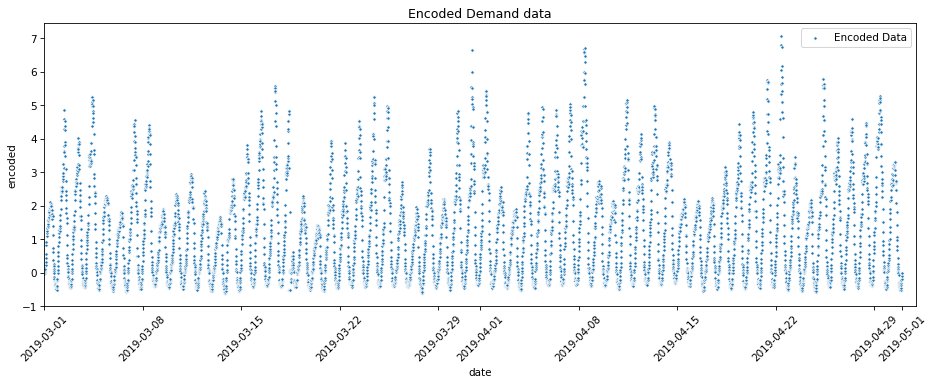

In [22]:
fig, ax = plt.subplots(figsize=(15,5), dpi=75)
# Saving data/notebook size. For better plot, Comment out the line above and uncomment the one below.
# fig, ax = plt.subplots(figsize=(100,10), dpi=100)
# Adding date and demand
ax = sns.scatterplot(x=encoded_data.index,y=encoded_data['encoded'],label = 'Encoded Data', s=10)
ax.set_xlim([pd.to_datetime('2019-02-28 23:50:00'), pd.to_datetime('2019-05-02 00:10:00')])
ax.set_title('Encoded Demand data')
# Rotate the dates
for item in ax.get_xticklabels():
    item.set_rotation(45)

### Encoder Results

Below are the results of the RMS for the encoder-decoder model for the entire data. Adding the masking values had an improvement in the RMS because it does not have to get the RMS for values that were original not in the pivot table. This means that the values where there was data predicted by the Autoencoder were ignored(masked out).

In [0]:
print('RMS for unmasked decoder: ',RMS(upsample.values,decoded))
print('RMS for masked decoder: ', RMS(upsample.values,mask_.values*decoded))

# 7 New Autoencoder Train

## Define New Model

In [0]:
# New Autoencoder
import keras
from keras.layers import Dense, Input, Dropout
from keras.models import Model
from keras.initializers import glorot_normal
keras.initializers.glorot_normal(seed=11)

input_array = Input(shape=(1329,),name='Input')
encoded = Dense(units = 512, activation='relu', kernel_initializer='glorot_normal', name='enc_1')(input_array)
encoded = Dropout(rate=0.5, name='dropout_1')(encoded)
encoded = Dense(units = 256, activation='relu', kernel_initializer='glorot_normal', name='enc_2')(encoded)
encoded = Dropout(rate=0.5, name='dropout_2')(encoded)
encoded = Dense(units = 128, activation='relu', kernel_initializer='glorot_normal', name='enc_3')(encoded)
encoded = Dropout(rate=0.5, name='dropout_3')(encoded)
encoded = Dense(units = 10, activation='relu', kernel_initializer='glorot_normal', name='enc_4')(encoded)
# encoded = Dropout(rate=0.5, name='dropout_4')(encoded)
encoded = Dense(units = 1, activation='linear', name='enc_final')(encoded)
decoded = Dense(units = 32, activation='relu', name='dec_1')(encoded)
decoded = Dropout(rate=0.5, name='dropout_5')(decoded)
decoded = Dense(units = 128, activation='relu', kernel_initializer='glorot_normal', name='dec_2')(decoded)
decoded = Dropout(rate=0.5, name='dropout_6')(decoded)
decoded = Dense(units = 256, activation='relu', kernel_initializer='glorot_normal', name='dec_3')(decoded)
decoded = Dropout(rate=0.5, name='dropout_7')(decoded)
decoded = Dense(units = 512, activation='relu', kernel_initializer='glorot_normal', name='dec_4')(decoded)
decoded = Dropout(rate=0.5, name='dropout_8')(decoded)
decoded = Dense(units = 1329, activation='linear', kernel_initializer='glorot_normal', name='dec_final')(decoded)

In [32]:
auto_encoder_2=Model(input_array,decoded)
auto_encoder_2.summary()
encoder_2= Model(input_array,encoded)
encoder_2.summary()
decoder_input = Input(shape=(1,))
decoded = auto_encoder_2.layers[-9](decoder_input)
decoded = auto_encoder_2.layers[-8](decoded)
decoded = auto_encoder_2.layers[-7](decoded)
decoded = auto_encoder_2.layers[-6](decoded)
decoded = auto_encoder_2.layers[-5](decoded)
decoded = auto_encoder_2.layers[-4](decoded)
decoded = auto_encoder_2.layers[-3](decoded)
decoded = auto_encoder_2.layers[-2](decoded)
decoded = auto_encoder_2.layers[-1](decoded)

decoder_2=Model(decoder_input,decoded)
decoder_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 1329)              0         
_________________________________________________________________
enc_1 (Dense)                (None, 512)               680960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
enc_2 (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
enc_3 (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

In [0]:
adam = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
sgd = keras.optimizers.SGD(lr=0.01, momentum=0.9)
Early_Stop = keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=15, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_mean_squared_error', factor=0.05,patience=5, min_lr=0.0005, mode='auto')
auto_encoder_2.reset_states()

In [34]:
%%time
auto_encoder_2.compile(optimizer=adam, loss='mse', metrics=['mse'])
history = auto_encoder_2.fit(upsample.values[:4000],upsample.values[:4000],
                epochs=100,
                batch_size=256,
                verbose=1,
                callbacks=[Early_Stop,reduce_lr],
                validation_data=(upsample.values[4000:5000],upsample.values[4000:5000])
                )

Train on 4000 samples, validate on 1000 samples
Epoch 1/100
4000/4000 [==============================] - 3s 825us/step - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 2/100
4000/4000 [==============================] - 2s 416us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 3/100
4000/4000 [==============================] - 2s 412us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 4/100
4000/4000 [==============================] - 2s 403us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 5/100
4000/4000 [==============================] - 2s 409us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 6/100
4000/4000 [==============================] - 2s 402us/step - loss: 0.0029 - mean_squared_error: 0.0029 - 

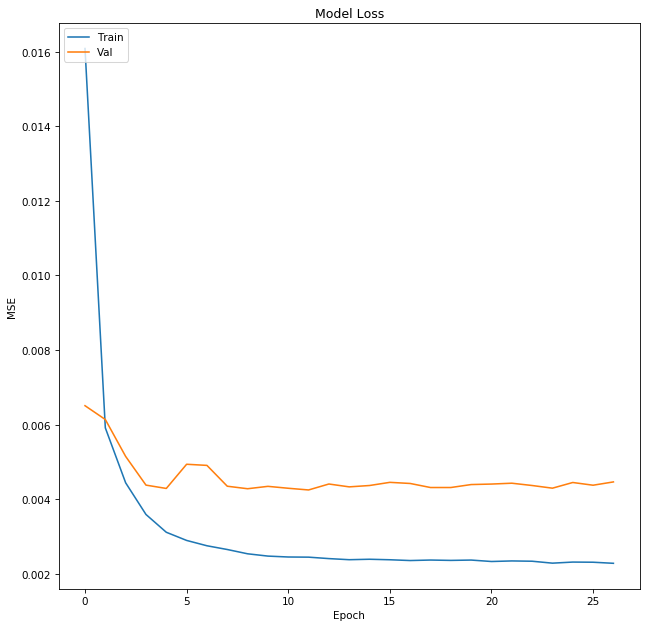

In [35]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model Loss')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### Retrained Autoencoder Results

In [36]:
%%time
encoded_2 = encoder_2.predict(upsample.values[:])
encoded_data_2 = pd.DataFrame(index = upsample.index, columns=['encoded'])
encoded_data_2['encoded'] = encoded_2
print('Maximum Encoded data: {}\nMinimum Encoded data: {}'.format(encoded_data_2.max(),encoded_data_2.min()))
encoded_data_2=encoded_data_2.astype({'encoded':np.float64})
encoded_data_2.info()
decoded_2 = decoder_2.predict(encoded_data_2['encoded'])

Maximum Encoded data: encoded   -0.036806
dtype: float32
Minimum Encoded data: encoded   -6.735324
dtype: float32
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 2019-03-01 00:00:00 to 2019-04-30 23:45:00
Data columns (total 1 columns):
encoded    5856 non-null float64
dtypes: float64(1)
memory usage: 91.5 KB
CPU times: user 2.34 s, sys: 72.5 ms, total: 2.42 s
Wall time: 1.78 s


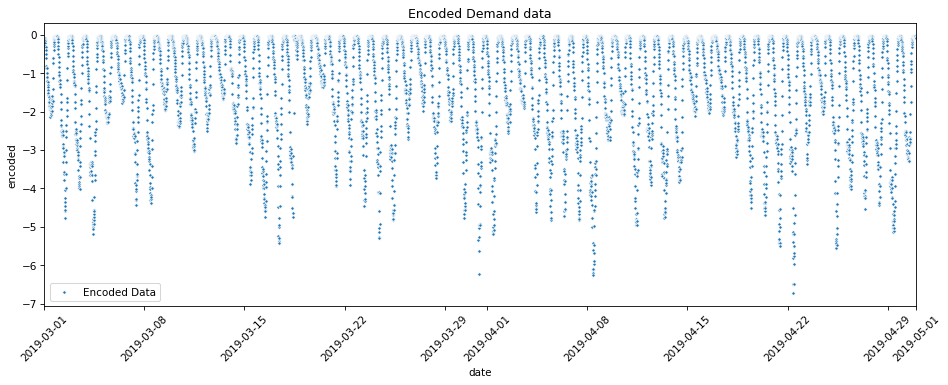

In [37]:
fig, ax = plt.subplots(figsize=(15,5), dpi=75)
# Saving data/notebook size. For better plot, Comment out the line above and uncomment the one below.
# fig, ax = plt.subplots(figsize=(100,10), dpi=100)
# Adding date and demand
ax = sns.scatterplot(x=encoded_data_2.index,y=encoded_data_2['encoded'],label = 'Encoded Data', s=10)
ax.set_xlim([pd.to_datetime('2019-02-28 23:50:00'), pd.to_datetime('2019-05-01 00:10:00')])
ax.set_title('Encoded Demand data')
# Rotate the dates
for item in ax.get_xticklabels():
    item.set_rotation(45)

In [38]:
print('Model RMS: {}\nMasked Model RMS: {}'.format(RMS(upsample.values,decoded_2),RMS(upsample.values,mask_.values*decoded_2)))

Model RMS: 0.05709792438986204
Masked Model RMS: 0.05687055291572112


## Saving Updated Autoencoder

In [54]:
%%time
auto_encoder_2.save('auto_encoder_Updated-June142019.h5')

CPU times: user 1.24 s, sys: 35.8 ms, total: 1.28 s
Wall time: 1.36 s


## Loading Updated Autoencoder



In [19]:
from keras.layers import Dense, Input, Dropout
from keras.models import Model
from keras.models import load_model

# auto_encoder = load_model('auto_encoder_06062019.h5')
auto_encoder_2 = load_model('auto_encoder_Updated-June142019.h5')
auto_encoder_2.summary()

Using TensorFlow backend.
W0615 11:06:09.068581 139734831495040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0615 11:06:09.089890 139734831495040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0615 11:06:09.106477 139734831495040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0615 11:06:09.107527 139734831495040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_de

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 1329)              0         
_________________________________________________________________
enc_1 (Dense)                (None, 512)               680960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
enc_2 (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
enc_3 (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

In [20]:
encoder_2 = Model(auto_encoder_2.input,auto_encoder_2.layers[-10].output)
encoder_2.summary()
decoder_input = Input(shape=(1,))
decoded = auto_encoder_2.layers[-9](decoder_input)
decoded = auto_encoder_2.layers[-8](decoded)
decoded = auto_encoder_2.layers[-7](decoded)
decoded = auto_encoder_2.layers[-6](decoded)
decoded = auto_encoder_2.layers[-5](decoded)
decoded = auto_encoder_2.layers[-4](decoded)
decoded = auto_encoder_2.layers[-3](decoded)
decoded = auto_encoder_2.layers[-2](decoded)
decoded = auto_encoder_2.layers[-1](decoded)

decoder_2=Model(decoder_input,decoded)
decoder_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 1329)              0         
_________________________________________________________________
enc_1 (Dense)                (None, 512)               680960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
enc_2 (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
enc_3 (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

Testing out the loaded encoder

Maximum Encoded data: encoded    7.058011
dtype: float32
Minimum Encoded data: encoded   -0.616193
dtype: float32
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 2019-03-01 00:00:00 to 2019-04-30 23:45:00
Data columns (total 1 columns):
encoded    5856 non-null float64
dtypes: float64(1)
memory usage: 91.5 KB
RMS for unmasked decoder:  0.04841032076493373
RMS for masked decoder:  0.047637445429661016
CPU times: user 1.78 s, sys: 187 ms, total: 1.97 s
Wall time: 1.27 s


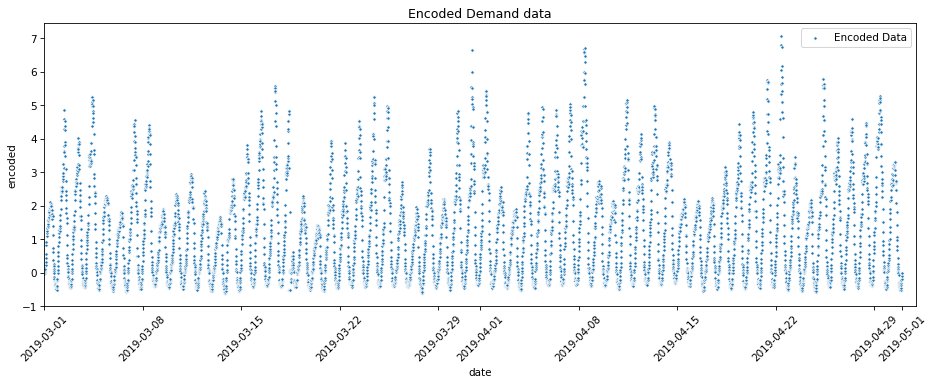

In [21]:
%%time
encoded = encoder_2.predict(upsample.values[:])
encoded_data_2 = pd.DataFrame(index = upsample.index, columns=['encoded'])
encoded_data_2['encoded'] = encoded
print('Maximum Encoded data: {}\nMinimum Encoded data: {}'.format(encoded_data_2.max(),encoded_data_2.min()))
encoded_data_2=encoded_data_2.astype({'encoded':np.float64})
encoded_data_2.info()
decoded = decoder_2.predict(encoded_data_2['encoded'])

fig, ax = plt.subplots(figsize=(15,5), dpi=75)
# Saving data/notebook size. For better plot, Comment out the line above and uncomment the one below.
# fig, ax = plt.subplots(figsize=(100,10), dpi=100)
# Adding date and demand
ax = sns.scatterplot(x=encoded_data_2.index,y=encoded_data_2['encoded'],label = 'Encoded Data', s=10)
ax.set_xlim([pd.to_datetime('2019-02-28 23:50:00'), pd.to_datetime('2019-05-02 00:10:00')])
ax.set_title('Encoded Demand data')
# Rotate the dates
for item in ax.get_xticklabels():
    item.set_rotation(45)

print('RMS for unmasked decoder: ',RMS(upsample.values,decoded))
print('RMS for masked decoder: ', RMS(upsample.values,mask_.values*decoded))

## Saving Encoded Data for EDA use

In [0]:
encoded_data_2.to_pickle("Encoded_data.pkl")

# 8 LSTM Model

## Data Prep

### Training Set

In [0]:
def create_test_train_lstm(dataset,current,walk_forward,f_step):
    from tqdm import tqdm_notebook
    
    X_train, y_train = [], []
#     for i in tqdm_notebook(range(walk_forward-f_step)): # Will not include last f_steps
    for i in tqdm_notebook(range(walk_forward)):
        X_train.append(np.array(dataset.values[-(lookback+current)+i:-(current)+i]).reshape(lookback,1))
        y_train.append(np.array(dataset.values[-(current)+i:-(current)+i+f_step]))
    print('Training Set Created')
    return np.array(X_train),np.array(y_train)

In [23]:
dataset = encoded_data_2['encoded']
lookback=25
f_step = 5
walk_forward=5000
current = 5800

X_train,y_train = create_test_train_lstm(dataset=dataset,current=current,walk_forward=walk_forward,f_step=f_step)


Training Set Created


### Test Set

In [121]:
dataset = encoded_data_2['encoded']
lookback=25
f_step = 5
walk_forward=1000
current = 1800

X_test,y_test = create_test_train_lstm(dataset=dataset,current=current,walk_forward=walk_forward,f_step=f_step)


Training Set Created


In [122]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(4000, 25, 1) (4000, 5) (1000, 25, 1) (1000, 5)


## Loading the Pretrained Model

Since the LSTM model has been trained I can simply call it up.

In [24]:
Forecast_LSTM = load_model('Forecast_LSTM-June142019.h5')
Forecast_LSTM.summary()

W0615 11:06:32.623227 139734831495040 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_1 (LSTM)                (None, 25, 256)           264192    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 25, 256)           0         
_________________________________________________________________
LSTM_2 (LSTM)                (None, 25, 128)           197120    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 25, 128)           0         
_________________________________________________________________
LSTM_FIN (LSTM)              (None, 64)                49408     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
Dense_1 (Dense)              (None, 64)                4160      
__________

### Running Predictions on the Trained Model

In [0]:
def create_test_train_lstm(dataset,current,walk_forward,f_step):
    from tqdm import tqdm_notebook
    
    X_train, y_train = [], []
    # for i in tqdm_notebook(range(walk_forward-f_step)): # Will not include last f_steps
    for i in tqdm_notebook(range(walk_forward)):
        X_train.append(np.array(dataset.values[-(lookback+current)+i:-(current)+i]).reshape(lookback,1))
        y_train.append(np.array(dataset.values[-(current)+i:-(current)+i+f_step]))
    print('Training Set Created')
    return np.array(X_train),np.array(y_train)


def LSTM_WALK(dataset=dataset,lookback = lookback,current = current,walk_forward=walk_forward,f_step=f_step):
    '''
    Makes the forward walk for the LSTM Model
    '''   

    X_train,y_train = create_test_train_lstm(dataset=dataset,current=current,walk_forward=walk_forward,f_step=f_step)
    from tqdm import tqdm_notebook
    import keras
    from keras.layers import Dense, Input, Dropout, LSTM,LeakyReLU
    from keras.models import Sequential
    from keras.models import load_model
    Forecast_LSTM = load_model('Forecast_LSTM-June142019.h5')
    # Forecast_LSTM.summary()
    true = dataset[-(current):-(current-walk_forward)]
    y_hat_LSTM = []
    predictions = Forecast_LSTM.predict(X_train)
    for i in range(walk_forward):
        y_hat = predictions[i]
        y_hat_LSTM.append(predictions[i][0])
        
    LSTM_Res = pd.DataFrame(columns= ['true','preds'])
    LSTM_Res['true'] = true
    LSTM_Res['preds'] = y_hat_LSTM
    return LSTM_Res, y_hat

In [44]:
dataset = encoded_data_2['encoded']
lookback=25
f_step = 5
walk_forward=5000
current = 5800
LSTM_forecast_walk, LSTM_y_hat_last= LSTM_WALK(dataset=dataset,lookback = lookback,current = current,walk_forward=walk_forward,f_step=f_step)
forecast_frame = LSTM_forecast_walk['preds']
decoded_model_score = get_score(forecast_frame,current,walk_forward)
score,decoded_model_score_five = final_five_score(dataset,LSTM_y_hat_last,current,walk_forward,f_step)


Training Set Created
Full Decoded Model Score:  0.04799721207245744
Encoded Preds Score: 0.11226518870580794
Final Five Model Score:  0.04560558876349163


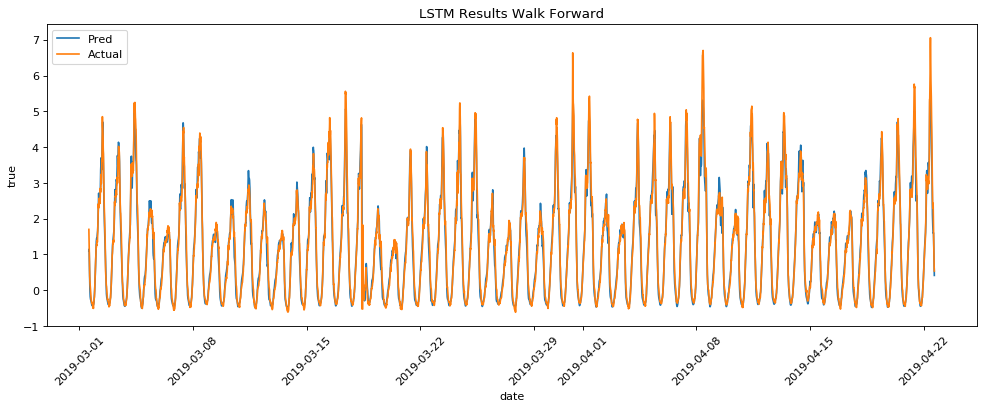

In [45]:
fig, ax = plt.subplots(figsize=(15,5), dpi=80)
# Saving data/notebook size. For better plot, Comment out the line above and uncomment the one below.
# fig, ax = plt.subplots(figsize=(100,10), dpi=100)

# ax = sns.scatterplot(x=LSTM_forecast_walk.index, y=LSTM_forecast_walk['preds'], label='Pred', s=8)
# ax = sns.scatterplot(x=LSTM_forecast_walk.index, y=LSTM_forecast_walk['true'], label='Actual', s=8)
ax = sns.lineplot(x=LSTM_forecast_walk.index, y=LSTM_forecast_walk['preds'], label='Pred', markersize=4)
ax = sns.lineplot(x=LSTM_forecast_walk.index, y=LSTM_forecast_walk['true'], label='Actual', markersize=4)
ax.set_title('LSTM Results Walk Forward')

# Rotate the X labels
for item in ax.get_xticklabels():
    item.set_rotation(45)

In [0]:
forecast_walk, logs_walk, y_hat_last= WALK_ARIMA(dataset = dataset, lookback = lookback,current=current, walk_point = walk_point, f_steps = f_steps)
forecast_frame = forecast_walk['preds']
decoded_model_score = get_score(forecast_frame,current,walk_point)
score,decoded_model_score_five = final_five_score(dataset,y_hat_last,current,walk_point,f_steps)

We can see that the results are pretty close to the actual values. This is only possible if we consider only the first prediction $\(t+1)$ instead of the first five $\(t+1) ... (t+5)$. Still its amazing how close we are getting to the plot of the actual.

## LSTM Model

In [0]:
import keras
from keras.layers import Dense, Input, Dropout, LSTM,LeakyReLU
from keras.models import Sequential
from keras.models import load_model


Forecast_LSTM = Sequential()
Forecast_LSTM.add(LSTM(units=256, return_sequences=True, input_shape=(X_train.shape[1], 1),name='LSTM_1',kernel_initializer='glorot_uniform'))
Forecast_LSTM.add(LeakyReLU(0.5))
Forecast_LSTM.add(LSTM(units=128, dropout=0.5,name='LSTM_2', kernel_initializer='glorot_uniform', return_sequences=True))
Forecast_LSTM.add(LeakyReLU(0.5))
Forecast_LSTM.add(LSTM(units=64, dropout=0.5,name='LSTM_FIN', return_sequences=False))
Forecast_LSTM.add(LeakyReLU(0.5))
Forecast_LSTM.add(Dense(units=64, kernel_initializer='glorot_uniform',name='Dense_1'))
Forecast_LSTM.add(LeakyReLU(0.5))
Forecast_LSTM.add(Dropout(rate=0.5, name='dropout_1'))
Forecast_LSTM.add(Dense(units=32, kernel_initializer='glorot_uniform',name='Dense_2'))
Forecast_LSTM.add(LeakyReLU(0.5))
Forecast_LSTM.add(Dropout(rate=0.5, name='dropout_2'))
Forecast_LSTM.add(Dense(units=5, activation='linear', kernel_initializer='glorot_uniform',name='Final'))

In [134]:
Forecast_LSTM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_1 (LSTM)                (None, 25, 256)           264192    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 25, 256)           0         
_________________________________________________________________
LSTM_2 (LSTM)                (None, 25, 128)           197120    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 25, 128)           0         
_________________________________________________________________
LSTM_FIN (LSTM)              (None, 64)                49408     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
Dense_1 (Dense)              (None, 64)                4160      
__________

## LSTM Train

In [0]:
adam = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
sgd = keras.optimizers.SGD(lr=0.01, momentum=0.9)
Early_Stop = keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=15, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_mean_squared_error', factor=0.05,patience=5, min_lr=0.0005, mode='auto')
Forecast_LSTM.reset_states()

In [136]:
Forecast_LSTM.compile(optimizer=sgd, loss='mse', metrics=['mse'])
history_LSTM = Forecast_LSTM.fit(X_train[:-800],y_train[:-800],
                epochs=150,
                batch_size=64,
                verbose=1,
                callbacks=[Early_Stop,reduce_lr],
                validation_data=(X_train[-800:],y_train[-800:])
                )

Train on 3200 samples, validate on 800 samples
Epoch 1/150
3200/3200 [==============================] - 19s 6ms/step - loss: 1.7796 - mean_squared_error: 1.7796 - val_loss: 1.2367 - val_mean_squared_error: 1.2367
Epoch 2/150
3200/3200 [==============================] - 14s 4ms/step - loss: 0.7315 - mean_squared_error: 0.7315 - val_loss: 0.3959 - val_mean_squared_error: 0.3959
Epoch 3/150
3200/3200 [==============================] - 15s 5ms/step - loss: 0.5160 - mean_squared_error: 0.5160 - val_loss: 0.5634 - val_mean_squared_error: 0.5634
Epoch 4/150
3200/3200 [==============================] - 15s 5ms/step - loss: 0.4986 - mean_squared_error: 0.4986 - val_loss: 0.4063 - val_mean_squared_error: 0.4063
Epoch 5/150
3200/3200 [==============================] - 14s 4ms/step - loss: 0.4424 - mean_squared_error: 0.4424 - val_loss: 0.3375 - val_mean_squared_error: 0.3375
Epoch 6/150
3200/3200 [==============================] - 14s 4ms/step - loss: 0.3907 - mean_squared_error: 0.3907 - val_los

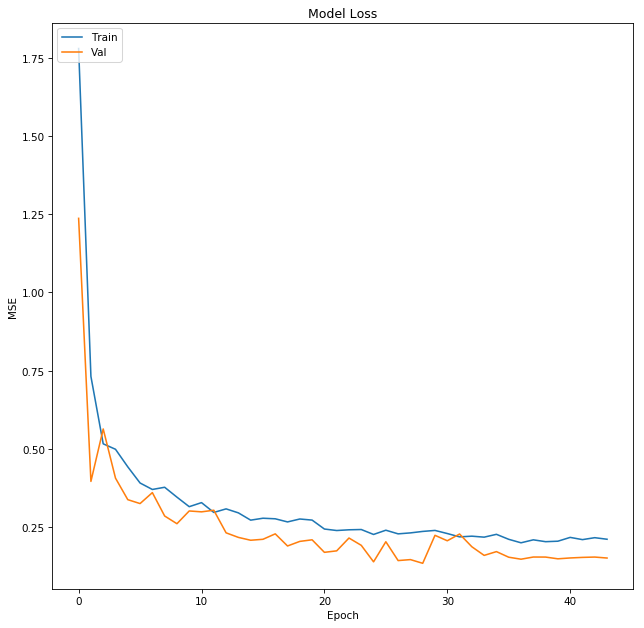

In [137]:
plt.plot(history_LSTM.history['mean_squared_error'])
plt.plot(history_LSTM.history['val_mean_squared_error'])
plt.title('Model Loss')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### LSTM Results

In [0]:
true = encoded_data_2['encoded'][-(current):-(current-walk_forward)]
y_hat_LSTM = []
predictions = Forecast_LSTM.predict(X_test)
for i in range(walk_forward):
    y_hat_LSTM.append(predictions[i][0])
    
LSTM_Res = pd.DataFrame(columns= ['true','preds'])
LSTM_Res['true'] = true
LSTM_Res['preds'] = y_hat_LSTM

In [0]:
def get_score(forecast_frame,current,walk_point):
    decoded_SARIMA = decoder_2.predict(forecast_frame)# note:  using decoder 2
    actual_SARIMA = upsample[-current:(-current+walk_point)] # - current : -current + f_steps
    mask_SARIMA = mask_[-current:(-current+walk_point)] # - current : -current + f_steps
    masked_SARIMA = pd.DataFrame(decoded_SARIMA*mask_SARIMA,columns=upsample.columns)
    model_score = RMS(masked_SARIMA.values,actual_SARIMA.values)
    print('Full Decoded Model Score: ',model_score)
    return model_score

In [140]:
get_score(forecast_frame=LSTM_Res['preds'],current=current,walk_point=walk_forward)

Full Decoded Model Score:  0.05717271955511025


0.05717271955511025

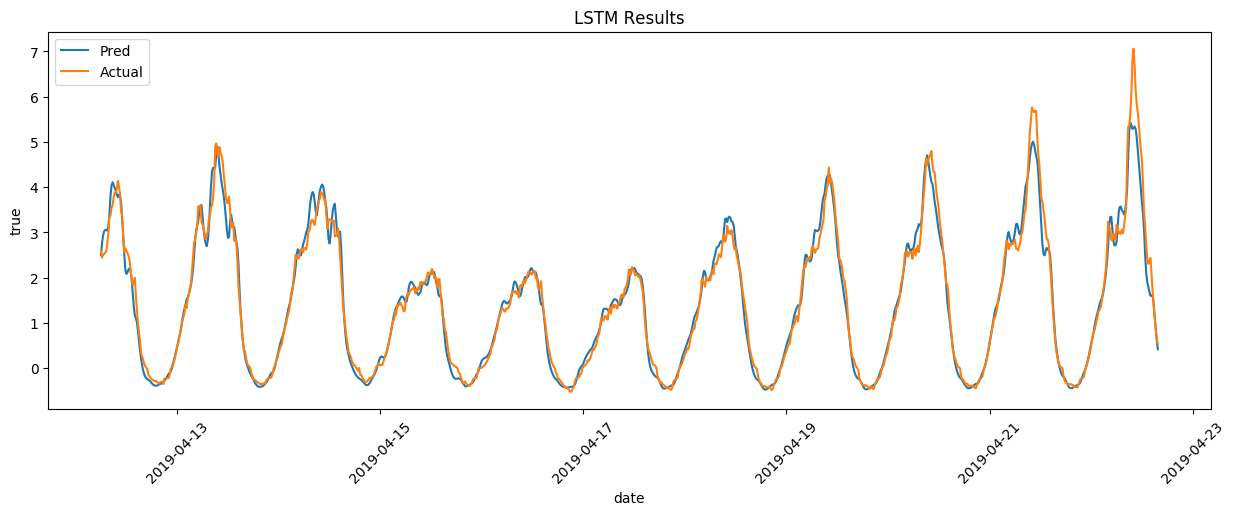

In [141]:
fig, ax = plt.subplots(figsize=(15,5), dpi=100)
# Saving data/notebook size. For better plot, Comment out the line above and uncomment the one below.
# fig, ax = plt.subplots(figsize=(100,10), dpi=100)

# ax = sns.scatterplot(x=LSTM_Res.index, y=LSTM_Res['preds'], label='Pred', s=8)
# ax = sns.scatterplot(x=LSTM_Res.index, y=LSTM_Res['true'], label='Actual', s=8)
ax = sns.lineplot(x=LSTM_Res.index, y=LSTM_Res['preds'], label='Pred', markersize=4)
ax = sns.lineplot(x=LSTM_Res.index, y=LSTM_Res['true'], label='Actual', markersize=4)
ax.set_title('LSTM Results')

# Rotate the X labels
for item in ax.get_xticklabels():
    item.set_rotation(45)

In [0]:
final_five_score(dataset,y_hat_last,current,walk_point,f_steps)

## Save LSTM Model

In [0]:
Forecast_LSTM.save('Forecast_LSTM-June142019.h5')

# 9 ARIMA/SARIMA Model

## Hyperparameter search

Using the gridsearch code provided in [How to Develop Deep Learning Models for Univariate Time Series Forecasting](https://machinelearningmastery.com/how-to-develop-deep-learning-models-for-univariate-time-series-forecasting/) I was able to narrow down the list of hyperparameters for the model. Early on I decided to focus more on the lower order hyperparameters to save time. This is somehow supported by the ACF and PACF plot earlier. From what I understand on the topic, the PACF and ACF will help guide us on the number of relevant AR and MA values.

The question would be is it a SARIMA or ARIMA model? This was what I was trying to figure out when doing these tests. Since I am new to time-series problems and have no prior experience with ARIMA/SARIM I was a bit lost on which was appropriate. From reading through some medium posts what I understood was that SARIMA is used for ARIMA data that will have seasonality to it. But what is seasonality? How do I know if there is seasonality? Lot's of questions and the deadline was approaching so I figured I might as well try to hit two birds with one stone by grid-searching SARIMA. The worst possible scenario that can happen is that the SARIMA model parameters simply churns out ARIMA Model values, no seasonal (P,D,Q)m.

In [0]:
# SOURCE: https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/


# grid search sarima hyperparameters for monthly mean temp dataset
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pandas import read_csv
from tqdm import tqdm_notebook

# one-step sarima forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]
 
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error
 
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.5f' % (key, result))
	return (key, result)
 
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in tqdm_notebook(cfg_list))
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in tqdm_notebook(cfg_list)]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores
 
# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [0]
	d_params = [0]
	q_params = [0]
	t_params = ['n','t','c','ct']
	P_params = [1]
	D_params = [0]
	Q_params = [0,2]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models
 
if __name__ == '__main__':
	# load dataset
	series = encoded_data_2['encoded']
	data = series.values
	# trim dataset to 5 years
	data = data[-(500):]
	# data split
	n_test = 5
	# model configs
	cfg_list = sarima_configs(seasonal=[0,96])
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

Interestingly, the best RMS score I had while grid-searching was `[(0, 0, 0), (1, 0, 0, 0), 'c'] 0.004634905424127102` and followed closely by `[(1, 0, 0), (0, 0, 0, 0), 'c'] 0.004640885184639894
`. So what I arrived at was two options, either use a model as a SARIMAX with a seasonal AR of 1 and a constant trend or I could revert it to a simple ARIMA model with an AR of 1.

## Walkforward



In [0]:
def WALK_ARIMA(dataset, lookback = 1344,current=500, walk_point = 1, f_steps = 5):

    '''
    INPUTS:
    
    dataset = The encoded data to be used.
    parameters = The combination of Parameters based on get_params_list
    lookback = *Window Size*, number of sequences considered for fitting the model. Defaults to 1300 (approx. 13.5 days)
    current = Pointer of the start of the testing
    stop_point = Number of predictions to get.
    f_steps = Number of sequences to forecast per prediction
    
    OUTPUTS:
    Final_results = Log of the Gridsearch for ARIMA Model
    model = best model found via gridsearch
    y_hat = list of forecasts using the best model
    score = RMS score for the forecasted values
    forecast_frame = Log of the true and forecasted value based on the best model
    forecast_best = Complete result of forecasts from the model. Includes Errors
    '''
    import warnings
    warnings.filterwarnings("ignore")
    from statsmodels.tsa.arima_model import ARIMA
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from tqdm import tqdm_notebook
    import time

    window = dataset.values[-(lookback+current):-(current)]
    Series = dataset.values
    results = []
    logs = []
    true_list = []
    moving_window = [x for x in window]
    running_score = []
    for i in tqdm_notebook(range(walk_point)): # This will fit and update when a new data becomes available.
#     for i in tqdm_notebook(range(0,walk_point,5)): # This will fit and update every 5 timesteps.
        try:
            # Try to fit the window to SARIMA
            model = SARIMAX(moving_window, order = (0,0,0), seasonal_order= (1,0,0,0), trend='c', enforce_stationarity=False, enforce_invertibility=False).fit()
            forecast_best = model.forecast(steps=f_steps)
            y_hat = forecast_best.tolist()
            used = 'Sarima'
        except:
            # If the SARIMA is invalid for the window use ARIMA
            model = ARIMA(moving_window, order = (1,0,0)).fit()
            forecast_best = model.forecast(steps=f_steps)
            y_hat = forecast_best[0].tolist()
            used = 'Arima'
        results.append(y_hat[0])
#         moving_window.append(y_hat[0]) ## Uncomment this if we are going to use the Predicted Values as input.
        moving_window.append(Series[-current+i])
        moving_window = moving_window[1:] ## Using the True value for use on the next target.
        logs.append(y_hat)
        true_list.append(Series[-current+i])
        forecast_frame = pd.DataFrame(columns = ['preds','true','scores'])
        forecast_frame['preds'] = results
        forecast_frame['true'] = true_list
        score=RMS(forecast_frame['preds'],forecast_frame['true'])
        running_score.append(score)
#         print('Using: {}\t RMS: {}'.format(used,score))
    forecast_frame['scores'] = running_score
    print('Walk forward Completed!')
    return forecast_frame,logs, y_hat

## ARIMA Findings

The upside of SARIMA/ARIMA is that they can do a fairly accurate prediction at the first few steps. The problem with it is that when we do walkforward while using the predicted data as the input, we are actually getting worse and worse predcitions mainly because the errors would start to propagate. This requires us to constantly feed the true values to the model window prior to predicting the next sequence.

We can opt to update the readings every time a new data has been collected, in this case every 15-minutes. Or we can choose to wait for the 5 15-minute sequences to be completed and use that to get the next 5 15-minute sequence forecasts.

The pros of doing the constant update is that it will lead to better forecasting accuracy since our model is always updated. The downside is that it will require us to constantly get updated values and run the predictions every 15 minutes. On the otherhand, waiting and using the next 5 sequences will reduce the ammount of computation we have to make but the cons is that it will be less accurate the farther we are from the time the forecast was calculated.

It all boils down to how important accuracy is versus computational costs in terms of the business objectives. I am assuming a more accurate forecast would be a better fit in this case. The computational costs for updating the forecasts every 15-minutes should be justifiable if the accuracy is of prime importance.

###  Grid Searching for Lookback values

Since we now have a scoring metric to guage scores we can proceed with finding the final hyperparamter for the SARIMA model. This is going to be the lookback size or basically the window size. This dictates how far back the data are considered when fitting the model and getting the forecast. Based on the challenge rules we are only allowed to consider at most 14 consecutive days from the model. The results of the search showed that I might want to consider 20-30 sequences worth of data or around 4-7 hours worth of data. For the final model I set the window size to 25 which is equivalent to 6 hours and 15 minutes worth of sequences.

In [42]:
from tqdm import tqdm_notebook
dataset = encoded_data_2['encoded']
current = 4000
walk_point = 50
f_steps = 5
lookback_tally = []
decoded_tally = []
final_five_score_tally = []
for lookback in tqdm_notebook(range(20,30,1)):#):
    
    forecast_walk, logs_walk, y_hat_last= WALK_ARIMA(dataset = dataset, lookback = lookback,current=current, walk_point = walk_point, f_steps = f_steps)
    forecast_frame = forecast_walk['preds']
    print('Lookback: ',lookback)
    decoded_model_score = get_score(forecast_frame,current,walk_point)
    score,decoded_model_score_five = final_five_score(dataset,y_hat_last,current,walk_point,f_steps)
    lookback_tally.append(lookback)
    decoded_tally.append(decoded_model_score)
    final_five_score_tally.append(decoded_model_score_five)

grid_ = pd.DataFrame(columns = ['lookback','decoded_running','final_five'])
grid_['lookback'] = lookback_tally
grid_['decoded_running'] = decoded_tally
grid_['final_five'] = final_five_score_tally

Walk forward Completed!
Lookback:  20
Full Decoded Model Score:  0.04579273597620692
Encoded Preds Score: 0.07137208473458911
Final Five Model Score:  0.03558166158914653


Walk forward Completed!
Lookback:  21
Full Decoded Model Score:  0.04580433458357514
Encoded Preds Score: 0.07427014462047656
Final Five Model Score:  0.03558330597113442


Walk forward Completed!
Lookback:  22
Full Decoded Model Score:  0.0458285590226273
Encoded Preds Score: 0.07249452341730428
Final Five Model Score:  0.03558233281240677


Walk forward Completed!
Lookback:  23
Full Decoded Model Score:  0.04585126945944623
Encoded Preds Score: 0.0735643166111203
Final Five Model Score:  0.0355829313887251


Walk forward Completed!
Lookback:  24
Full Decoded Model Score:  0.04586880140221899
Encoded Preds Score: 0.07504875886136325
Final Five Model Score:  0.03558391296615556


Walk forward Completed!
Lookback:  25
Full Decoded Model Score:  0.045861303977216626
Encoded Preds Score: 0.05696068271687964
Final Five Model Score:  0.03557220416439653


Walk forward Completed!
Lookback:  26
Full Decoded Model Score:  0.045852859492514136
Encoded Preds Score: 0.04674638168652908
Final Five Model Score:  0.035566459851338376


Walk forward Completed!
Lookback:  27
Full Decoded Model Score:  0.04584762159166127
Encoded Preds Score: 0.06628761038544627
Final Five Model Score:  0.03557852523777758


Walk forward Completed!
Lookback:  28
Full Decoded Model Score:  0.04584261763360558
Encoded Preds Score: 0.06792044214531248
Final Five Model Score:  0.03557907372725818


Walk forward Completed!
Lookback:  29
Full Decoded Model Score:  0.0458266605822049
Encoded Preds Score: 0.09324975269858168
Final Five Model Score:  0.03559206350729107



In [43]:
grid_

,lookback,decoded_running,final_five
0,20,0.045793,0.035582
1,21,0.045804,0.035583
2,22,0.045829,0.035582
3,23,0.045851,0.035583
4,24,0.045869,0.035584
5,25,0.045861,0.035572
6,26,0.045853,0.035566
7,27,0.045848,0.035579
8,28,0.045843,0.035579
9,29,0.045827,0.035592


### Final SARIMA Model Hyperparameters

In [0]:
dataset = encoded_data_2['encoded']
lookback = 25
current = 5800# how far back (negative value)
f_steps = 5
walk_point = 5000

In [47]:
ARIMA_forecast_walk, ARIMA_logs_walk, ARIMA_y_hat_last= WALK_ARIMA(dataset = dataset, lookback = lookback,current=current, walk_point = walk_point, f_steps = f_steps)
forecast_frame = ARIMA_forecast_walk['preds']
decoded_model_score = get_score(forecast_frame,current,walk_point)
score,decoded_model_score_five = final_five_score(dataset,ARIMA_y_hat_last,current,walk_point,f_steps)


Walk forward Completed!
Full Decoded Model Score:  0.047628137137281694
Encoded Preds Score: 0.5420875215449955
Final Five Model Score:  0.05273289978053191


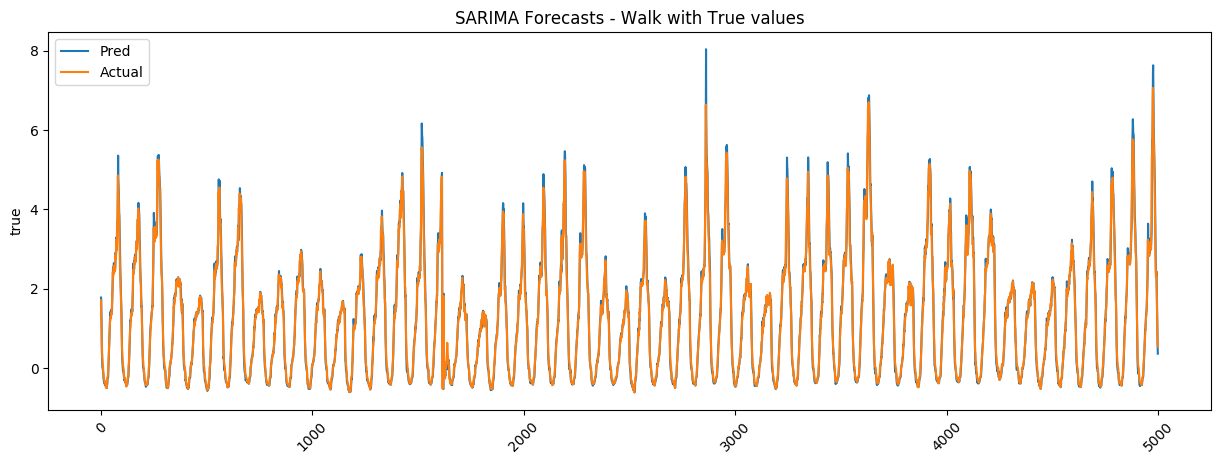

In [48]:
fig, ax = plt.subplots(figsize=(15,5), dpi=100)
# Saving data/notebook size. For better plot, Comment out the line above and uncomment the one below.
# fig, ax = plt.subplots(figsize=(100,10), dpi=100)

# ax = sns.scatterplot(x=ARIMA_forecast_walk.index, y=ARIMA_forecast_walk['preds'], label='Pred', s=8)
# ax = sns.scatterplot(x=ARIMA_forecast_walk.index, y=ARIMA_forecast_walk['true'], label='Actual', s=8)
ax = sns.lineplot(x=ARIMA_forecast_walk.index, y=ARIMA_forecast_walk['preds'], label='Pred', markersize=4)
ax = sns.lineplot(x=ARIMA_forecast_walk.index, y=ARIMA_forecast_walk['true'], label='Actual', markersize=4)
ax.set_title('SARIMA Forecasts - Walk with True values')

# Rotate the X labels
for item in ax.get_xticklabels():
    item.set_rotation(45)

The plot above shows the results of the model at its current configuration.

* Lookback/Window Size = 25 sequences<br>
* SARIMA parameters:
    * order = (1,0,0)
    * seasonal_order= (1,0,0,0)
    * trend='c'

# 10 FB Prophet

Tested but not pursued due to low score and high compute time.

## Data Prep

In [0]:
prophet = encoded_data_2.reset_index()
prophet = prophet.rename(columns={'date':'ds','encoded':'y'})

## Moving Window Forecasting

In [0]:
dataset = prophet
lookback=25
f_step = 5
walk_forward=50
current = 5800

In [0]:
y_hat_fb = []
y_hat_up_fb = []
y_hat_low_fb = []
y_true = []
date =[]

In [107]:
prophet_train = []
prophet_test = []

from tqdm import tqdm_notebook
for i in tqdm_notebook(range(walk_forward)):
    
    prophet_train.append(dataset[-(lookback+current)+i:-(current)+i])
    prophet_test.append(dataset[-(current)+i:-(current)+i+f_step])
    model = Prophet(daily_seasonality=False,weekly_seasonality=False,yearly_seasonality=False)
    model.fit(prophet_train[i])
    future = prophet_test[i]
    forecast = model.predict(future)
    y_hat_fb.append(forecast['yhat'].iloc[0])
    y_hat_up_fb.append(forecast['yhat_upper'].iloc[0])
    y_hat_low_fb.append(forecast['yhat_lower'].iloc[0])
    y_true.append(dataset['y'].iloc[-current+i])
    date.append(dataset['ds'].iloc[-current+i])

I0615 09:12:23.775469 140661363734400 forecaster.py:363] n_changepoints greater than number of observations.Using 19.
I0615 09:12:25.785257 140661363734400 forecaster.py:363] n_changepoints greater than number of observations.Using 19.
I0615 09:12:27.950603 140661363734400 forecaster.py:363] n_changepoints greater than number of observations.Using 19.
I0615 09:12:30.086228 140661363734400 forecaster.py:363] n_changepoints greater than number of observations.Using 19.
I0615 09:12:32.085647 140661363734400 forecaster.py:363] n_changepoints greater than number of observations.Using 19.
I0615 09:12:34.094465 140661363734400 forecaster.py:363] n_changepoints greater than number of observations.Using 19.
I0615 09:12:36.102502 140661363734400 forecaster.py:363] n_changepoints greater than number of observations.Using 19.
I0615 09:12:38.105696 140661363734400 forecaster.py:363] n_changepoints greater than number of observations.Using 19.
I0615 09:12:40.129641 140661363734400 forecaster.py:363]

In [0]:
prophet_results = pd.DataFrame(columns = ['date','y_hat_fb','y_hat_up_fb','y_hat_low_fb','y_true'])
prophet_results['date'] = date
prophet_results['y_hat_fb'] = y_hat_fb
prophet_results['y_hat_up_fb'] = y_hat_up_fb
prophet_results['y_hat_low_fb'] = y_hat_low_fb
prophet_results['y_true'] = y_true

## Prophet Prediction Score

Below is the RMS score for the Encoded data prediction of FB Prophet. Its quite low at 0.43 but considering that our LSTM and Sarimax model produced RMS in the neighborhood of 0.06 this score is relatively bad.

In [109]:
RMS(prophet_results['y_hat_fb'],prophet_results['y_true'])

0.4319773953345759

## Predictions Plot

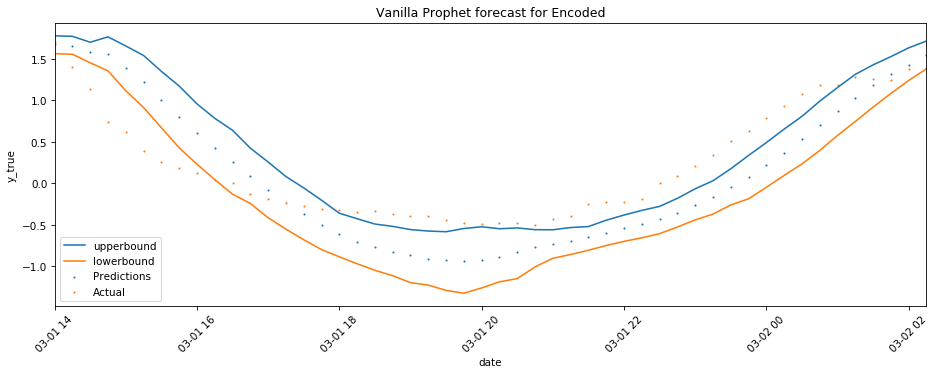

In [114]:
fig, ax = plt.subplots(figsize=(15,5), dpi=75)
# Saving data/notebook size. For better plot, Comment out the line above and uncomment the one below.
# fig, ax = plt.subplots(figsize=(100,10), dpi=100)
# Adding date and demand
# Forecast Set
ax = sns.scatterplot(x=prophet_results['date'], y=prophet_results['y_hat_fb'], label='Predictions', s=8) # Predictions
ax = sns.lineplot(x=prophet_results['date'], y=prophet_results['y_hat_up_fb'], label='upperbound', markersize=8) # Upper Confidence level
ax = sns.lineplot(x=prophet_results['date'], y=prophet_results['y_hat_low_fb'], label='lowerbound', markersize=8) # Lower Confidence Level
ax = sns.scatterplot(x=prophet_results['date'], y=prophet_results['y_true'], label='Actual', s=8)
# ax = sns.lineplot(x=prophet_results['date'], y=prophet_results['y_true'], label='Actual', markersize=8) # uncomment this line if you prefer the lineplot, Make sure to comment out scatter.

ax.set_xlim([prophet_results['date'].min(), prophet_results['date'].max()])
ax.set_title('Vanilla Prophet forecast for Encoded')
# Rotate the dates
for item in ax.get_xticklabels():
    item.set_rotation(45)

FB Prophet could be promising but in this use case, with a limited lookback period it is limited and the RMS score on the encoded and decoded values alone are not convincing enough to pursue this further. Also, there is an added issue on generating predictions using rolling window in Prophet given the size of the dataset. Getting 5000 predictions from it would require 3 hours (approx.). Given the score it showed on the limited run I decided not to dive into this further.

There is merit on FB Prophet for longer lookback windows since it gets to consider more data but for the use case I have I did not get a convinincing score so on to the next.

# Ensembling

Trying to check in this section if we can improve the Encoded prediction RMSE results throught the use of ensembling methods.

* Random Forrest Regression
* Linear Regression with EleasticNet Regularization
* MLP
* AdaBoostRegressor
* GradientBoostRegressor

## Creating the Features

In [54]:
ARIMA_forecast_walk['preds'].head()

0    1.772707
1    1.730733
2    1.443000
3    1.044527
4    0.399761
Name: preds, dtype: float64

In [0]:
ensemble = pd.DataFrame(columns = ['true','ARIMA','LSTM', 'ARIMA_UP','ARIMA_LOW','LSTM_UP','LSTM_LOW'])
ensemble['true'] = LSTM_forecast_walk['true']
ensemble['ARIMA'] = ARIMA_forecast_walk['preds'].values
ensemble['LSTM'] = LSTM_forecast_walk['preds']
ensemble['LSTM_UP'] = ensemble['LSTM']*1.05
ensemble['LSTM_LOW'] = ensemble['LSTM']*0.95
ensemble['ARIMA_UP'] = ensemble['ARIMA']*1.05
ensemble['ARIMA_LOW'] = ensemble['ARIMA']*0.95

In [57]:
ensemble.head()

,true,ARIMA,LSTM,ARIMA_UP,ARIMA_LOW,LSTM_UP,LSTM_LOW
date,,,,,,,
2019-03-01 14:00:00,1.700389,1.772707,1.108264,1.861342,1.684071,1.163678,1.052851
2019-03-01 14:15:00,1.404607,1.730733,1.146368,1.817270,1.644196,1.203686,1.089049
2019-03-01 14:30:00,1.138244,1.443000,1.057348,1.515150,1.370850,1.110216,1.004481
2019-03-01 14:45:00,0.744793,1.044527,0.845158,1.096753,0.992301,0.887416,0.802900
2019-03-01 15:00:00,0.613350,0.399761,0.520825,0.419749,0.379773,0.546866,0.494783


In [0]:
RFR_X_train, RFR_y_train = ensemble.drop(['true'],axis=1)[:4000],ensemble.true[:4000]
RFR_X_test, RFR_y_test =  ensemble.drop(['true'],axis=1)[4000:],ensemble.true[4000:]
print(RFR_X_train.shape, RFR_y_train.shape, RFR_X_test.shape, RFR_y_test.shape)

## Cross validation scorer
NOTE: Source https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset?scriptVersionId=379783

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, RFR_X_train, RFR_y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, RFR_X_test, RFR_y_test, scoring = scorer, cv = 10))
    return(rmse)

## Random Forrest Regression

Inspirered by NOTE: Source https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset?scriptVersionId=379783

RMSE on Training set : 0.15040948408757765
RMSE on Test set : 0.13945348169092872


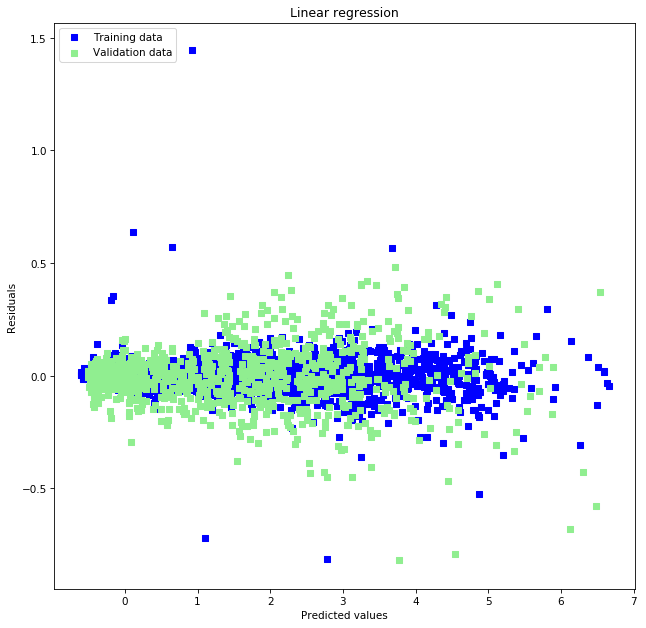

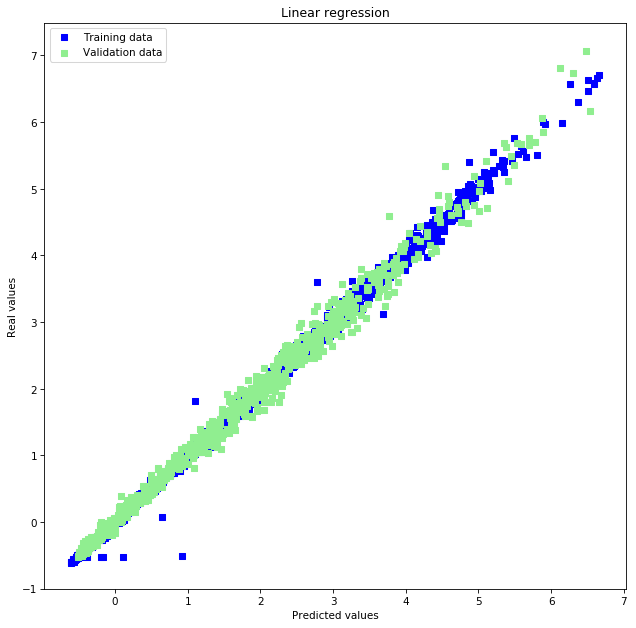

In [160]:
# 1. Random Forrest Regression

from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

model_RFR = RandomForestRegressor(n_jobs=-1,max_features=0.5, n_estimators = 300)
model_RFR.fit(RFR_X_train,RFR_y_train)

# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(model_RFR).mean())
print("RMSE on Test set :", rmse_cv_test(model_RFR).mean())
RFR_y_train_pred = model_RFR.predict(RFR_X_train)
RFR_y_test_pred = model_RFR.predict(RFR_X_test)

# Plot residuals
plt.scatter(RFR_y_train_pred, RFR_y_train_pred - RFR_y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(RFR_y_test_pred, RFR_y_test_pred - RFR_y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
# plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(RFR_y_train_pred, RFR_y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(RFR_y_test_pred, RFR_y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
# plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

In [0]:
RFR_full_pred = model_RFR.predict(ensemble.drop(['true'],axis=1))

In [161]:
dataset = encoded_data_2['encoded']
lookback = 25
current = 5800# how far back (negative value)
f_steps = 5
walk_point = 5000
forecast_frame = model_RFR.predict(ensemble.drop(['true'],axis=1))
decoded_model_score = get_score(forecast_frame,current,walk_point)
# score,decoded_model_score_five = final_five_score(dataset,ARIMA_y_hat_last,current,walk_point,f_steps)

Full Decoded Model Score:  0.04750792684210006


### Saving Model to Pickle

In [0]:
filename = 'model_RFR_06152019.sav'
pickle.dump(model_RFR, open(filename, 'wb'))

In [163]:
!ls

 aigrabsea_June3.ipynb		      encoder_06062019.h5
 auto_encoder_06062019.h5	      Forecast_LSTM-June142019.h5
 auto_encoder_Updated_06142019.h5     geo_mean_dict.pickle
 auto_encoder_Updated.h5	      heatmap
 auto_encoder_Updated-June142019.h5   heatmap-animation-WK2.gif
 auto_encoder_weights_06062019.h5     lat_lookup.pickle
'Copy of requirements.txt'	      line.gif
 data_encoded.pickle		      long_lookup.pickle
'Dataset-Explore(output-off).ipynb'   model_RFR_06152019.sav
 data_w_features.pickle		      requirements.txt
 decoder_06062019.h5		     'Traffic Management'
 EDA-Notes.ipynb		      traffic-management.zip
 Encoded_data.pkl


## RandomForestRegression Cross-Validation and Gridsearch

Since RandomForest is looking like the best candidate for the Ensemble I went ahead and performed optimization to see if the final decoded score can be improved.

[Original Reference](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)

In [147]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [150]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 35, 60, 85, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5],
 'n_estimators': [200, 650, 1100, 1550, 2000]}


In [151]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=1, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(RFR_X_train,RFR_y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 30.8min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [153]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 2000}

In [152]:
dataset = encoded_data_2['encoded']
lookback = 25
current = 5800# how far back (negative value)
f_steps = 5
walk_point = 5000
forecast_frame = rf_random.predict(ensemble.drop(['true'],axis=1))
decoded_model_score = get_score(forecast_frame,current,walk_point)

Full Decoded Model Score:  0.04759160881207501


## Linear Regression with Elasticnet Regularization

NOTE: Source https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset?scriptVersionId=379783

Best l1_ratio : 0.7
Best alpha : 0.0001
Try again for more precision with l1_ratio centered around 0.7
Best l1_ratio : 0.7
Best alpha : 0.0001
Now try again for more precision on alpha, with l1_ratio fixed at 0.7 and alpha centered around 0.0001
Best l1_ratio : 0.7
Best alpha : 8e-05
ElasticNet RMSE on Training set : 0.13907486071927
ElasticNet RMSE on Test set : 0.12444606541643237


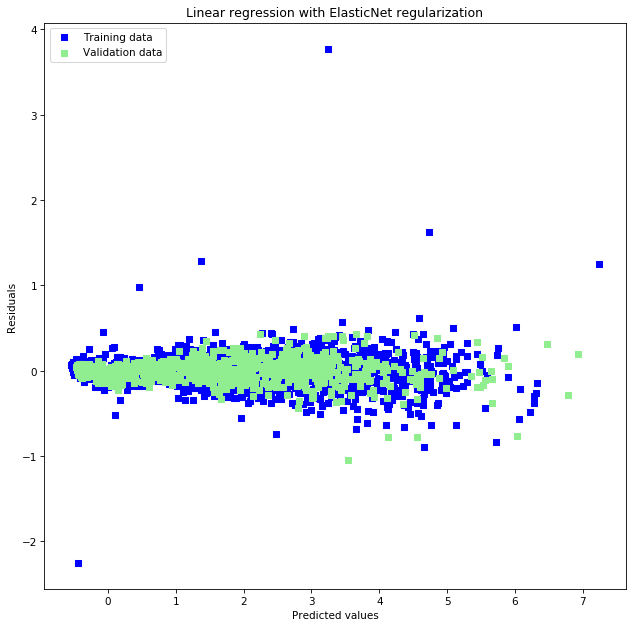

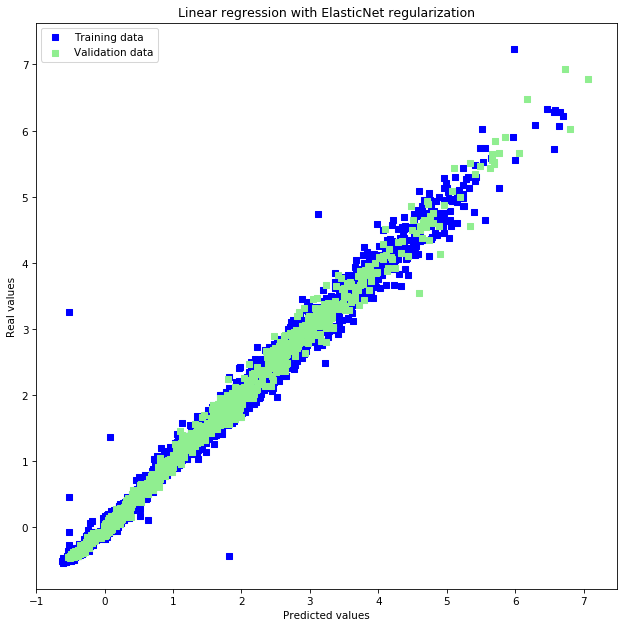

ElasticNet picked 4 features and eliminated the other 2 features


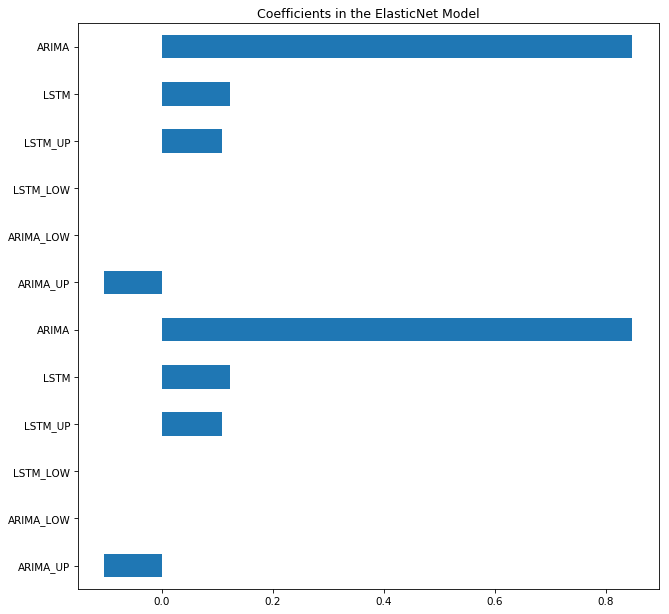

In [74]:
# NOTE: Source https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset?scriptVersionId=379783
# 4* ElasticNet
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(RFR_X_train, RFR_y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(RFR_X_train, RFR_y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(RFR_X_train, RFR_y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("ElasticNet RMSE on Training set :", rmse_cv_train(elasticNet).mean())
print("ElasticNet RMSE on Test set :", rmse_cv_test(elasticNet).mean())
RFR_y_train_ela = elasticNet.predict(RFR_X_train)
RFR_y_test_ela = elasticNet.predict(RFR_X_test)

# Plot residuals
plt.scatter(RFR_y_train_ela, RFR_y_train_ela - RFR_y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(RFR_y_test_ela, RFR_y_test_ela - RFR_y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
# plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(RFR_y_train, RFR_y_train_ela, c = "blue", marker = "s", label = "Training data")
plt.scatter(RFR_y_test, RFR_y_test_ela, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
# plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(elasticNet.coef_, index = RFR_X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()

In [75]:
dataset = encoded_data_2['encoded']
lookback = 25
current = 5800# how far back (negative value)
f_steps = 5
walk_point = 5000
forecast_frame = elasticNet.predict(ensemble.drop(['true'],axis=1))
decoded_model_score = get_score(forecast_frame,current,walk_point)
# score,decoded_model_score_five = final_five_score(dataset,ARIMA_y_hat_last,current,walk_point,f_steps)

Full Decoded Model Score:  0.04768464190607749


## MLP

In [142]:
## Repurposed the Autoencoder
import keras
from keras.layers import Dense, Input, Dropout, LeakyReLU
from keras.models import Model
from keras.initializers import glorot_normal
keras.initializers.glorot_normal(seed=22)

input_array = Input(shape=(6,),name='Input')
encoded = Dense(units = 1024, kernel_initializer='glorot_normal', name='ens_1')(input_array)
encoded = LeakyReLU(0.5)(encoded)
encoded = Dropout(rate=0.5, name='dropout_1')(encoded)

encoded = Dense(units = 512, kernel_initializer='glorot_normal', name='ens_2')(encoded)
encoded = LeakyReLU(0.5)(encoded)
encoded = Dropout(rate=0.5, name='dropout_2')(encoded)

encoded = Dense(units = 256, kernel_initializer='glorot_normal', name='ens_3')(encoded)
encoded = LeakyReLU(0.5)(encoded)
encoded = Dropout(rate=0.5, name='dropout_3')(encoded)

encoded = Dense(units = 128, kernel_initializer='glorot_normal', name='ens_4')(encoded)
encoded = LeakyReLU(0.5)(encoded)
encoded = Dropout(rate=0.5, name='dropout_4')(encoded)

encoded = Dense(units = 64, kernel_initializer='glorot_normal', name='ens_5')(encoded)
encoded = LeakyReLU(0.5)(encoded)
encoded = Dropout(rate=0.5, name='dropout_5')(encoded)

encoded = Dense(units = 1, name='enc_final')(encoded)
Ensemble=Model(input_array,encoded)
Ensemble.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
ens_1 (Dense)                (None, 1024)              7168      
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
ens_2 (Dense)                (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

In [0]:
adam = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
sgd = keras.optimizers.SGD(lr=0.01, momentum=0.9)
Early_Stop = keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=15, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_mean_squared_error', factor=0.05,patience=5, min_lr=0.0005, mode='auto')
Ensemble.reset_states()

In [144]:
Ensemble.compile(optimizer=adam, loss='mse', metrics=['mse'])
Ensemble_history = Ensemble.fit(RFR_X_train[:-1000], RFR_y_train[:-1000],
                epochs=100,
                batch_size=32,
                verbose=1,
                callbacks=[Early_Stop,reduce_lr],
                validation_data=(RFR_X_train[-1000:], RFR_y_train[-1000:])
                )

Train on 3000 samples, validate on 1000 samples
Epoch 1/100
3000/3000 [==============================] - 6s 2ms/step - loss: 108.7391 - mean_squared_error: 108.7391 - val_loss: 2.8084 - val_mean_squared_error: 2.8084
Epoch 2/100
3000/3000 [==============================] - 2s 527us/step - loss: 1.6837 - mean_squared_error: 1.6837 - val_loss: 0.5155 - val_mean_squared_error: 0.5155
Epoch 3/100
3000/3000 [==============================] - 2s 524us/step - loss: 0.8922 - mean_squared_error: 0.8922 - val_loss: 0.3922 - val_mean_squared_error: 0.3922
Epoch 4/100
3000/3000 [==============================] - 2s 532us/step - loss: 0.6199 - mean_squared_error: 0.6199 - val_loss: 0.1326 - val_mean_squared_error: 0.1326
Epoch 5/100
3000/3000 [==============================] - 2s 543us/step - loss: 0.5217 - mean_squared_error: 0.5217 - val_loss: 0.4089 - val_mean_squared_error: 0.4089
Epoch 6/100
3000/3000 [==============================] - 2s 543us/step - loss: 0.4449 - mean_squared_error: 0.4449 

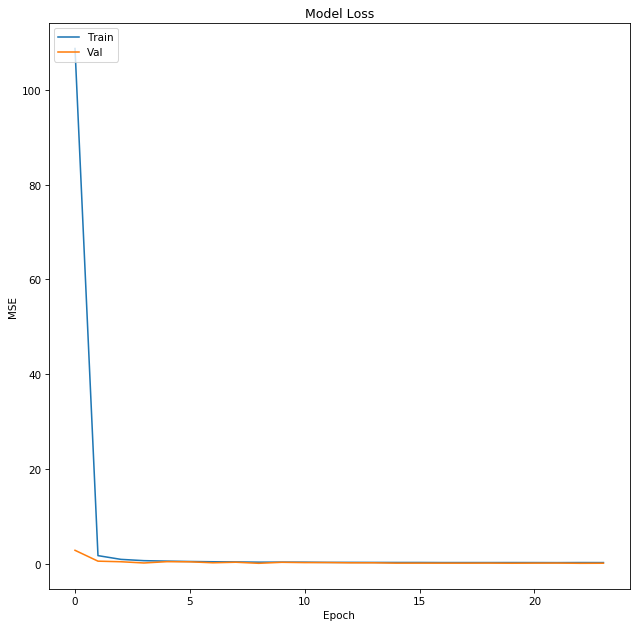

In [145]:
plt.plot(Ensemble_history.history['mean_squared_error'])
plt.plot(Ensemble_history.history['val_mean_squared_error'])
plt.title('Model Loss')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [146]:
dataset = encoded_data_2['encoded']
lookback = 25
current = 5800# how far back (negative value)
f_steps = 5
walk_point = 5000
Ensemble_preds_list = []
Ensemble_preds = Ensemble.predict(ensemble.drop(['true'],axis=1))
for i in range(walk_point):
    Ensemble_preds_list.append(Ensemble_preds[i][0])
forecast_frame_ens = pd.DataFrame(columns=['encoded','true'])
forecast_frame_ens['encoded'] = Ensemble_preds_list
decoded_model_score = get_score(forecast_frame_ens['encoded'],current,walk_point)

Full Decoded Model Score:  0.04823209704861522


In [123]:
type(Ensemble_preds[0])

numpy.float32

## ADABOOST

In [134]:
from sklearn.ensemble import AdaBoostRegressor
clf_ada = AdaBoostRegressor(n_estimators=1000, loss='exponential', learning_rate=0.01,)
clf_ada.fit(RFR_X_train, RFR_y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=0.01, loss='exponential',
                  n_estimators=1000, random_state=None)

In [135]:
clf_ada.feature_importances_

array([0.30253163, 0.02341248, 0.29820704, 0.33603917, 0.02028664,
       0.01952303])

In [136]:
dataset = encoded_data_2['encoded']
lookback = 25
current = 5800# how far back (negative value)
f_steps = 5
walk_point = 5000
forecast_frame = clf_ada.predict(ensemble.drop(['true'],axis=1))
decoded_model_score = get_score(forecast_frame,current,walk_point)

Full Decoded Model Score:  0.04788774337161242


## Gradient Boosting

In [140]:
from sklearn.ensemble import GradientBoostingRegressor

clf_GB = GradientBoostingRegressor(n_estimators=300)
clf_GB.fit(RFR_X_train, RFR_y_train)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=300,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [141]:
dataset = encoded_data_2['encoded']
lookback = 25
current = 5800# how far back (negative value)
f_steps = 5
walk_point = 5000
forecast_frame = clf_GB.predict(ensemble.drop(['true'],axis=1))
decoded_model_score = get_score(forecast_frame,current,walk_point)

Full Decoded Model Score:  0.04754839653384854


END